In [19]:
import sqlite3
import pandas as pd
import time
import re

class WeatherAnalysis:
    def __init__(self, db_name="weather_hypothesis.db"):
        self.conn = sqlite3.connect(db_name)
        self._create_table()

    def _create_table(self):
        query = """
        CREATE TABLE IF NOT EXISTS daily_weather (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            city TEXT,
            date TEXT,
            max_temp REAL,
            min_temp REAL,
            precip REAL,
            temp_diff REAL,
            UNIQUE(city, date)
        )
        """
        self.conn.execute(query)
        self.conn.commit()

    def save_data(self, data_list):
        query = "INSERT OR IGNORE INTO daily_weather (city, date, max_temp, min_temp, precip, temp_diff) VALUES (?, ?, ?, ?, ?, ?)"
        self.conn.executemany(query, data_list)
        self.conn.commit()

class WeatherScraper:
    def fetch_month(self, city_name, prec_no, block_no, year, month):
        url = f"https://www.data.jma.go.jp/obd/stats/etrn/view/daily_s1.php?prec_no={prec_no}&block_no={block_no}&year={year}&month={month}&day=&view="
        print(f"データ取得中: {city_name} ({year}/{month})")
        
        try:
            time.sleep(1.5) # サーバ負荷配慮
            dfs = pd.read_html(url)
            df = dfs[0]
            
            # --- 列の位置を「名前」で自動特定するロジック ---
            cols = [str(c) for c in df.columns]
            
            # 列名検索（階層構造の結合文字列から探す）
            idx_max = -1
            idx_min = -1
            idx_pre = -1

            for i, col_name in enumerate(cols):
                if '最高' in col_name and '気温' in col_name:
                    idx_max = i
                if '最低' in col_name and '気温' in col_name:
                    idx_min = i
                if '降水量' in col_name and '合計' in col_name: 
                    idx_pre = i
            
            # 見つからなかった場合の予備検索
            if idx_max == -1: idx_max = next((i for i, c in enumerate(cols) if '最高' in c), 7)
            if idx_min == -1: idx_min = next((i for i, c in enumerate(cols) if '最低' in c), 8)
            if idx_pre == -1: idx_pre = 3

            results = []
            for i in range(len(df)):
                row = df.iloc[i]
                day_str = str(row.iloc[0])
                if day_str.isdigit():
                    date_str = f"{year}-{month:02d}-{int(day_str):02d}"
                    
                    # --- 【修正箇所】どんな記号が来てもエラー落ちさせない関数 ---
                    def clean_val(val):
                        if pd.isna(val): return 0.0
                        s_val = str(val).strip()
                        if s_val in ['--', '///', '']: return 0.0 # 明らかな記号は0にする
                        
                        # 数字、ドット、マイナス以外を削除
                        res = re.sub(r'[^\d\.\-]', '', s_val)
                        
                        try:
                            # 変換トライ
                            return float(res)
                        except ValueError:
                            # どうしても変換できなければ 0.0 を返す（エラー回避）
                            return 0.0

                    precip = clean_val(row.iloc[idx_pre])
                    max_t  = clean_val(row.iloc[idx_max])
                    min_t  = clean_val(row.iloc[idx_min])
                    
                    # 念のため、気温が取得できなかった場合（0.0同士など）の考慮
                    # ただし今回は0.0として処理を進めます
                        
                    diff = round(max_t - min_t, 1)
                    results.append((city_name, date_str, max_t, min_t, precip, diff))
            return results
        except Exception as e:
            # ここでのエラーは全体を止めないように表示だけする
            print(f"警告: {city_name} の取得中に問題が発生しました ({e})")
            return []

if __name__ == "__main__":
    db = WeatherAnalysis()
    
    # DB初期化
    db.conn.execute("DELETE FROM daily_weather")
    db.conn.commit()
    print("DBをリセットしました。データ取得を開始します...")
    
    scraper = WeatherScraper()
    
    locations = [
        ("東京", "44", "47662"),
        ("大阪", "62", "47772"),
        ("福岡", "82", "47807"),
        ("札幌", "14", "47412"),
        ("那覇", "91", "47936")
    ]
    
    for city, p_no, b_no in locations:
        data = scraper.fetch_month(city, p_no, b_no, 2025, 12)
        if data:
            db.save_data(data)
        else:
            print(f"{city} のデータが空でした。")

    # 検証結果の簡易表示
    try:
        query = """
        SELECT 
            city,
            CASE WHEN precip = 0 THEN '降水なし' ELSE '降水あり' END AS condition,
            AVG(temp_diff) AS avg_diff,
            COUNT(*) AS days
        FROM daily_weather
        GROUP BY city, condition
        ORDER BY city, condition DESC
        """
        df_result = pd.read_sql_query(query, db.conn)
        print("\n--- 仮説検証結果 ---")
        print(df_result)
    except Exception as e:
        print(f"集計エラー: {e}")

DBをリセットしました。データ取得を開始します...
データ取得中: 東京 (2025/12)
データ取得中: 大阪 (2025/12)
データ取得中: 福岡 (2025/12)
データ取得中: 札幌 (2025/12)
データ取得中: 那覇 (2025/12)

--- 仮説検証結果 ---
  city condition  avg_diff  days
0   大阪      降水なし  8.296000    25
1   大阪      降水あり  6.450000     6
2   札幌      降水なし  6.350000     4
3   札幌      降水あり  5.774074    27
4   東京      降水なし  9.337500    24
5   東京      降水あり  6.500000     7
6   福岡      降水なし  7.842857    21
7   福岡      降水あり  7.390000    10
8   那覇      降水なし  5.382353    17
9   那覇      降水あり  4.921429    14


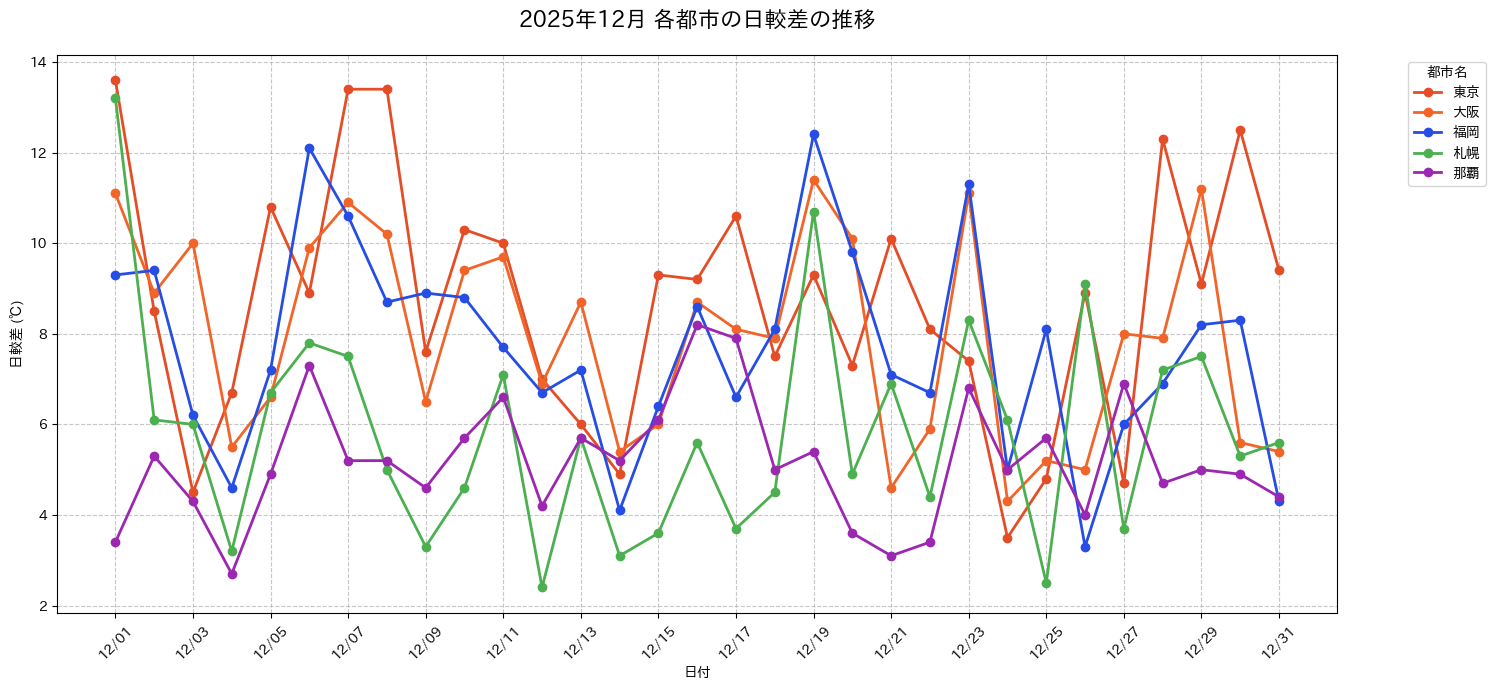

In [20]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import japanize_matplotlib

def plot_weather_analysis(db_name="weather_hypothesis.db"):
    conn = sqlite3.connect(db_name)
    query = "SELECT date, city, temp_diff FROM daily_weather ORDER BY date ASC"
    df = pd.read_sql_query(query, conn)
    conn.close()

    if df.empty: return

    df['date'] = pd.to_datetime(df['date'])
    plt.rcParams['font.family'] = 'IPAexGothic' 
    plt.figure(figsize=(15, 7))
    
    target_cities = ["東京", "大阪", "福岡", "札幌", "那覇"]
    colors = ['#E44D26', '#F16529', '#264DE4', '#4CAF50', '#9C27B0']
    
    for i, city in enumerate(target_cities):
        city_df = df[df['city'] == city]
        if not city_df.empty:
            plt.plot(city_df['date'], city_df['temp_diff'], marker='o', label=city, color=colors[i], linewidth=2)

    plt.title('2025年12月 各都市の日較差の推移', fontsize=16, pad=20)
    plt.xlabel('日付')
    plt.ylabel('日較差 (℃)')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='都市名', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_weather_analysis()

In [21]:
import sqlite3
import pandas as pd

def show_rankings(db_name="weather_hypothesis.db"):
    conn = sqlite3.connect(db_name)
    cities = ["東京", "大阪", "福岡", "札幌", "那覇"]
    
    for city in cities:
        print(f"\n{'='*20} {city} {'='*20}")
        query = f"SELECT date, temp_diff, precip FROM daily_weather WHERE city = '{city}'"
        df_city = pd.read_sql_query(query, conn)
        
        print("\n[上位10件：寒暖差大]")
        print(df_city.sort_values(by="temp_diff", ascending=False).head(10).to_string(index=False))
        
        print("\n[下位10件：寒暖差小]")
        print(df_city.sort_values(by="temp_diff", ascending=True).head(10).to_string(index=False))
    conn.close()

if __name__ == "__main__":
    show_rankings()


==================== 東京 ====================

[上位10件：寒暖差大]
      date  temp_diff  precip
2025-12-01       13.6     0.0
2025-12-07       13.4     0.0
2025-12-08       13.4     0.0
2025-12-30       12.5     0.0
2025-12-28       12.3     0.0
2025-12-05       10.8     0.0
2025-12-17       10.6     0.0
2025-12-10       10.3     0.0
2025-12-21       10.1     3.0
2025-12-11       10.0     0.0

[下位10件：寒暖差小]
      date  temp_diff  precip
2025-12-24        3.5     9.0
2025-12-03        4.5     0.0
2025-12-27        4.7     0.0
2025-12-25        4.8     3.5
2025-12-14        4.9     9.5
2025-12-13        6.0     2.0
2025-12-04        6.7     0.0
2025-12-12        7.0     0.0
2025-12-20        7.3     9.0
2025-12-23        7.4     0.0

==================== 大阪 ====================

[上位10件：寒暖差大]
      date  temp_diff  precip
2025-12-19       11.4     0.0
2025-12-29       11.2     0.0
2025-12-01       11.1     0.0
2025-12-23       11.1     6.0
2025-12-07       10.9     0.0
2025-12-08       10.2     